# ODEFormer experiment using SIR model

## Imports

In [1]:
from odeformer.model import SymbolicTransformerRegressor
from data_generation import ode_solver
import numpy as np
import matplotlib.pyplot as plt
from odeformer.metrics import r2_score, mean_squared_error
from types import SimpleNamespace

## Parameters of SIR model

In [2]:
days = 365
# Population size
init_S, init_I, init_R = 100, 2, 0
initial_conditions = [init_S, init_I, init_R]
# Population proportions
N = init_S + init_I + init_R
init_S_prop, init_I_prop, init_R_prop = init_S / N, init_I / N, init_R / N  
initial_conditions_prop = [init_S_prop, init_I_prop, init_R_prop]    
# Transmission and recovery rate
beta, gamma = 0.3, 0.1
times = np.arange(0, days, 1)

In [3]:
# Solution when using population size
sol = ode_solver(initial_conditions, times, beta, gamma, proportion=False)
S, I, R = sol.T
trajectory = np.stack([S, I, R], axis=1)

In [4]:
# Solution when using proportion
sol_prop = ode_solver(initial_conditions_prop, times, beta, gamma, proportion=True)
S_prop, I_prop, R_prop = sol_prop.T
trajectory_prop = np.stack([S_prop, I_prop, R_prop], axis=1)

## Determine the symbolic representation

In [ ]:
# Load the pre-trained model

# class Params:
#     def __init__(self):
#         self.init_scale = N
#         self.time_range = days

# params = Params()
# Adding the params to the dstr object results in an additional ODE being generated?

dstr = SymbolicTransformerRegressor(from_pretrained=True, rescale=True)
model_args = {'beam_size':50, 'beam_temperature':0.1}
dstr.set_model_args(model_args)

# Fit the model to the trajectory data for population size
candidates = dstr.fit(times, trajectory)
dstr.print(n_predictions=1) # Return the best symbolic expression - increase to see other candidates

Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = -0.2678 * x_0
x_1' = 0.2547 * x_1 + -0.0040 * x_1 * (0.8480 * x_1 + 1.0090 * x_2)
x_2' = 0.1244 * x_1 + -0.0027 * x_0


The true SIR model equations are:
\begin{align*} 
    \frac{dS}{dt} &= -\frac{\beta}{N}IS \\
    \frac{dI}{dt} &= \frac{\beta}{N}IS - \gamma I\\
    \frac{dR}{dt} &= \gamma I
\end{align*}
where $\beta=0.3$, $N=102$, and $\gamma=0.1$. Therefore $\frac{\beta}{N} \approx 0.002941$.

The estimated SIR model equations are:
\begin{align*} 
    \frac{dS}{dt} &= -0.2678 S \\
    \frac{dI}{dt} &= 0.2547 I - 0.004 I \times (0.848 I + 1.009 R)\\
    \\
    &= 0.2547 I - 0.003392 I^2 - 0.004036 IR \\
    \frac{dR}{dt} &= 0.1244 I - 0.0027 S
\end{align*}

In [6]:
# Predict the trajectory using the initial conditions and the fitted model (best candidate)
pred_trajectory = dstr.predict(times, trajectory[0])
print(r2_score(trajectory, pred_trajectory))
print(mean_squared_error(trajectory, pred_trajectory))

0.625597262587676
108.44677264924879


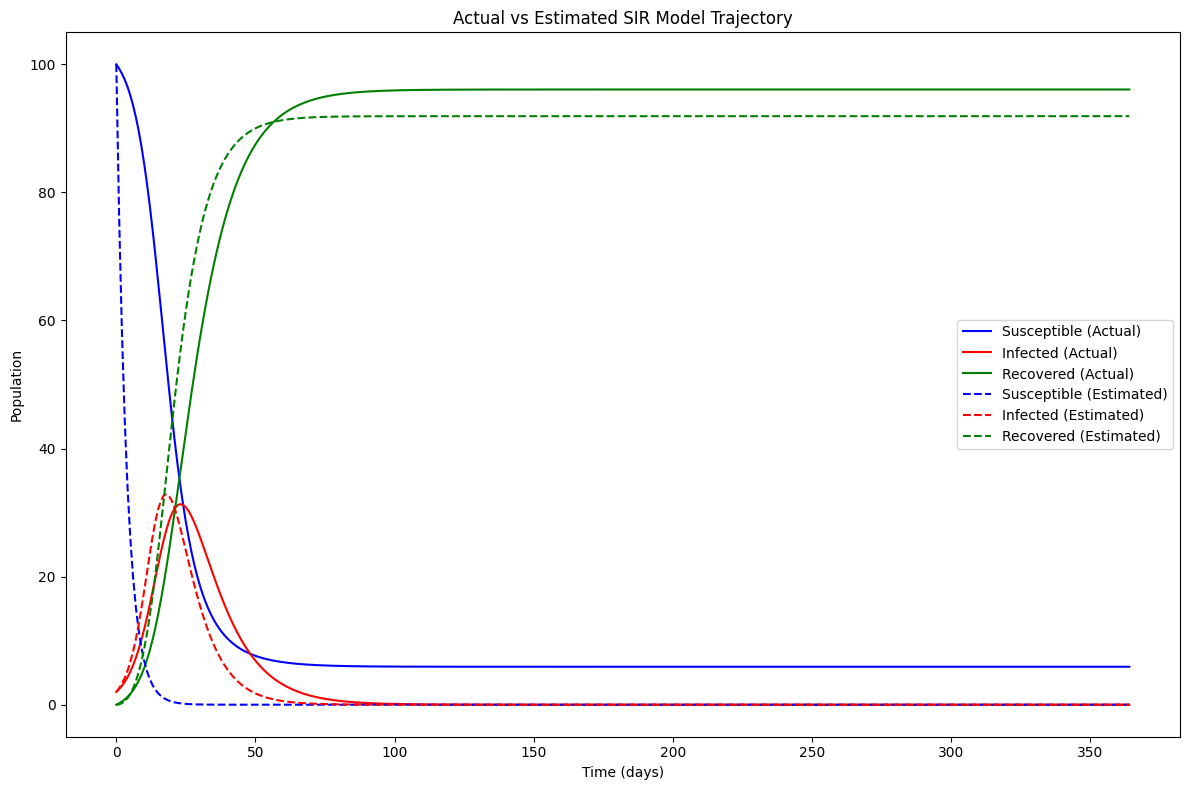

In [7]:
plt.figure(figsize=(12, 8))
# Actuals
plt.plot(times, S, label='Susceptible (Actual)', color='blue')
plt.plot(times, I, label='Infected (Actual)', color='red')
plt.plot(times, R, label='Recovered (Actual)', color = 'green')
# Estimates
plt.plot(times, pred_trajectory[:,0], label='Susceptible (Estimated)', color='blue', linestyle='dashed')
plt.plot(times, pred_trajectory[:,1], label='Infected (Estimated)', color='red', linestyle='dashed')
plt.plot(times, pred_trajectory[:,2], label='Recovered (Estimated)', color = 'green', linestyle='dashed')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('Actual vs Estimated SIR Model Trajectory')
plt.legend()
plt.tight_layout()
plt.show()

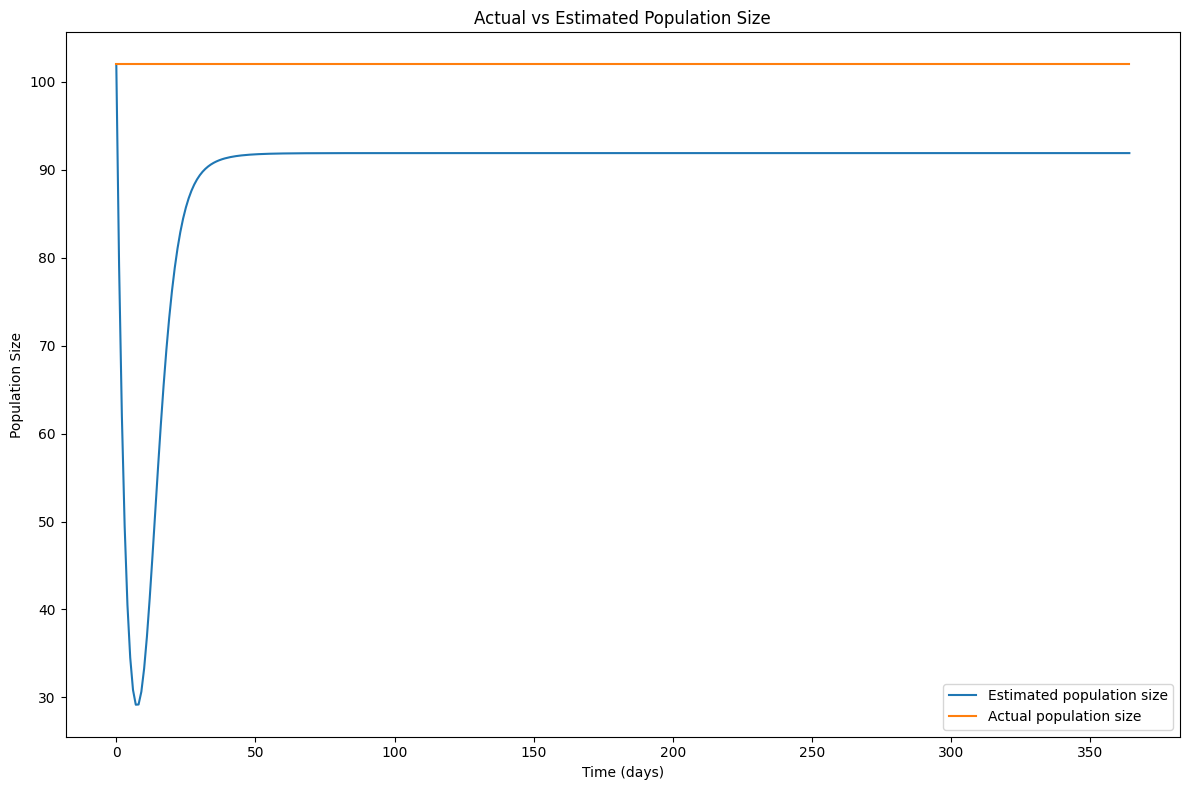

In [8]:
# Check if the total population is conserved
plt.figure(figsize=(12, 8))
plt.plot(times, np.sum(pred_trajectory, axis=1), label='Estimated population size')
plt.plot(times, np.sum(trajectory, axis=1), label='Actual population size')
plt.xlabel('Time (days)')
plt.ylabel('Population Size')
plt.title('Actual vs Estimated Population Size')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# Retry using proportion=True

# Load the pre-trained model
# class Params:
#     def __init__(self):
#         self.init_scale = 1
#         self.time_range = days

# params = Params()

dstr = SymbolicTransformerRegressor(from_pretrained=True, rescale=True)
model_args = {'beam_size':50, 'beam_temperature':0.1}
dstr.set_model_args(model_args)

# Fit the model to the trajectory data for population proportion
candidates = dstr.fit(times, trajectory_prop)
dstr.print(n_predictions=1) # Return the best symbolic expression - increase to see other candidates

Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = -1.2965 * x_1 * (x_0)**2
x_1' = 0.2591 * x_1 + -0.4604 * x_1 * x_2
x_2' = 1.3013 * x_1 + -14.2898 * x_0 * x_1 * x_2


The true SIR model equations are:
\begin{align*} 
    \frac{dS}{dt} &= -\beta IS \\
    \frac{dI}{dt} &= \beta IS - \gamma I\\
    \frac{dR}{dt} &= \gamma I
\end{align*}
where $\beta=0.3$, and $\gamma=0.1$.

The estimated SIR model equations are:
\begin{align*} 
    \frac{dS}{dt} &= -1.2965 I  S^2 \\
    \frac{dI}{dt} &= 0.2591 I - 0.4604 IR\\
    \frac{dR}{dt} &= 1.3013 I - 14.2898 S I R
\end{align*}

In [10]:
# Predict the trajectory using the initial conditions and the fitted model (best candidate)
pred_trajectory_prop = dstr.predict(times, trajectory_prop[0])
print(r2_score(trajectory_prop, pred_trajectory_prop))
print(mean_squared_error(trajectory_prop, pred_trajectory_prop))

0.6543882011303083
0.009484389867890288


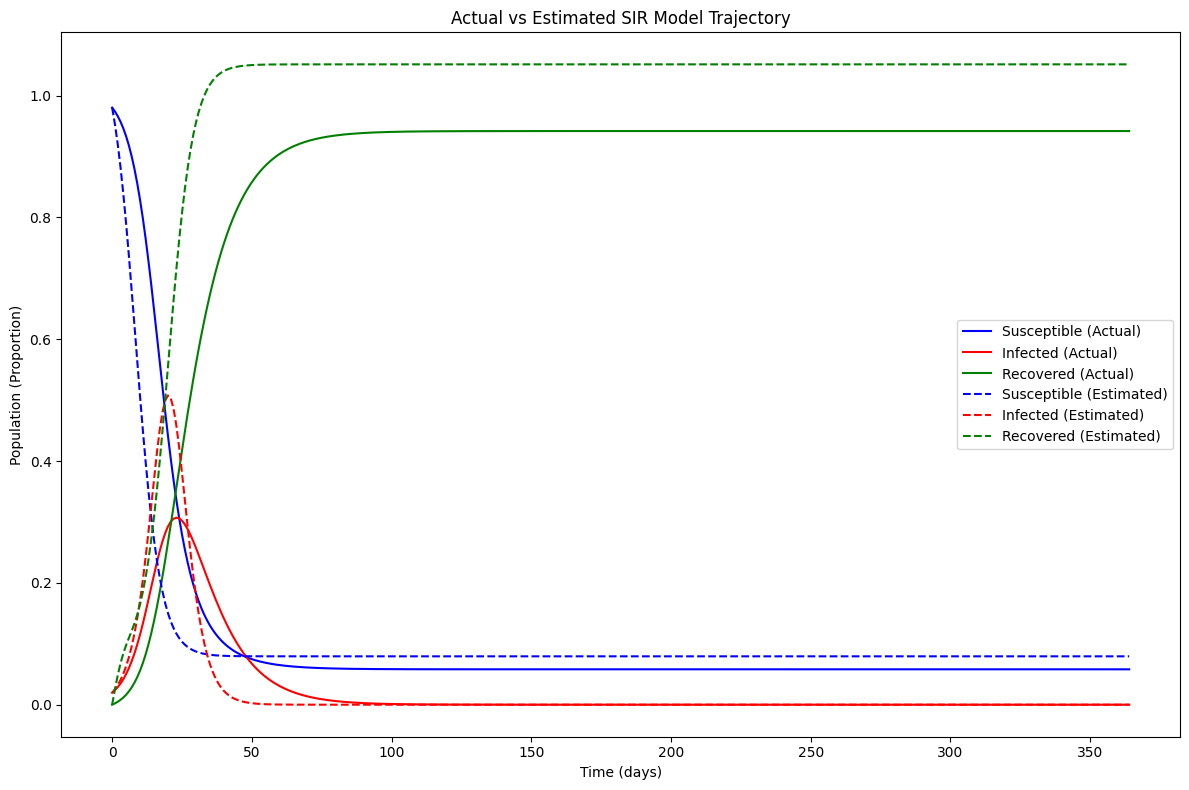

In [11]:
plt.figure(figsize=(12, 8))
# Actuals
plt.plot(times, S_prop, label='Susceptible (Actual)', color='blue')
plt.plot(times, I_prop, label='Infected (Actual)', color='red')
plt.plot(times, R_prop, label='Recovered (Actual)', color = 'green')
# Estimates
plt.plot(times, pred_trajectory_prop[:,0], label='Susceptible (Estimated)', color='blue', linestyle='dashed')
plt.plot(times, pred_trajectory_prop[:,1], label='Infected (Estimated)', color='red', linestyle='dashed')
plt.plot(times, pred_trajectory_prop[:,2], label='Recovered (Estimated)', color = 'green', linestyle='dashed')
plt.xlabel('Time (days)')
plt.ylabel('Population (Proportion)')
plt.title('Actual vs Estimated SIR Model Trajectory')
plt.legend()
plt.tight_layout()
plt.show()

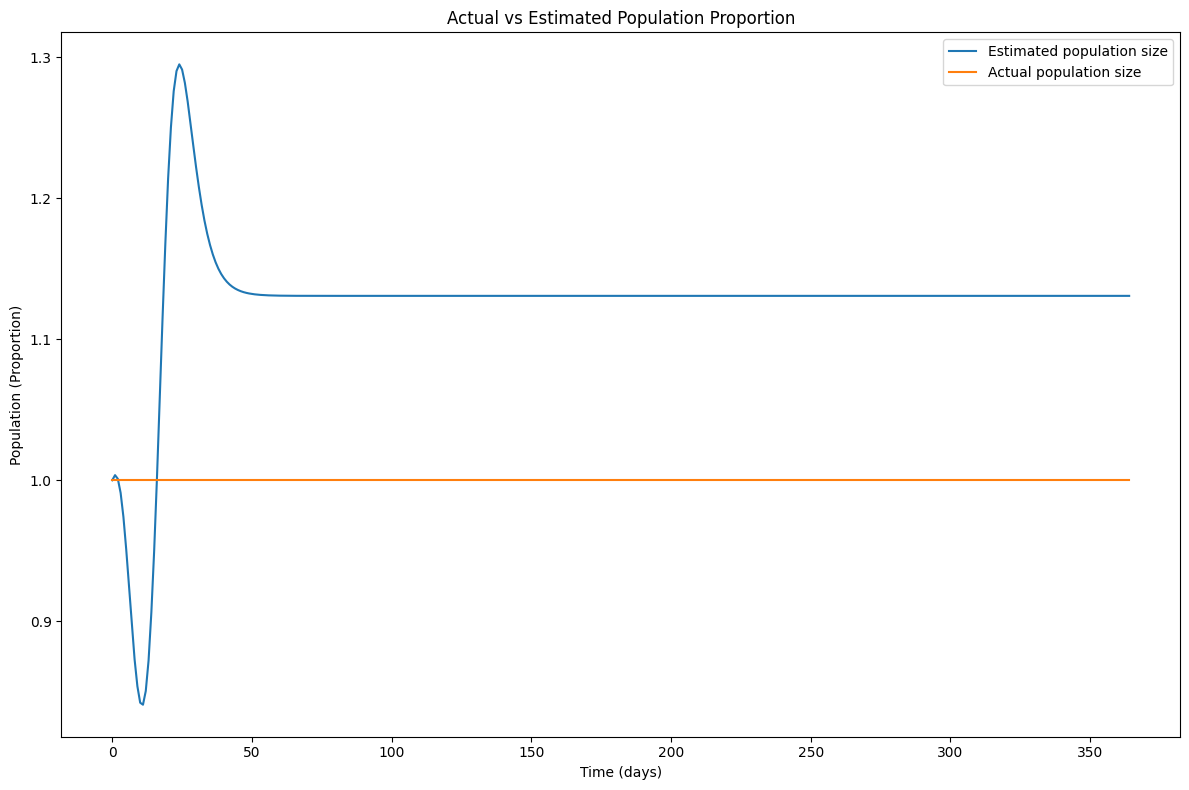

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(times, np.sum(pred_trajectory_prop, axis=1), label='Estimated population size')
plt.plot(times, np.sum(trajectory_prop, axis=1), label='Actual population size')
plt.xlabel('Time (days)')
plt.ylabel('Population (Proportion)')
plt.title('Actual vs Estimated Population Proportion')
plt.legend()
plt.tight_layout()
plt.show()